In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from nms import rle_decode

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
input_dir = "../../../kaggle-airbus/input"

Using TensorFlow backend.


## Configurations

In [2]:
class ShipsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "ships"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 768
    IMAGE_MAX_DIM = 768

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShipsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
class ShipsDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_ships(self, imageids):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("ship", 1, "ship")

        # Add images
        #df = pd.DataFrame(np.random.randn(100, 2))
        
        # valid image ids from submission file
        # masks = pd.read_csv(input_dir+'/train_ship_segmentations.csv')
        # Add images
            
        print('loading' , len(imageids), ' images')
            
        for image_id in imageids:
            self.add_image(
                "ship",
                image_id=image_id,
                path=input_dir + '/train/' + image_id)

    def image_reference(self, image_id):
        """Return the path of the image."""  
        info = self.image_info[image_id]
        if info["source"] == "ship":
            return info["ship"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        masks = pd.read_csv(input_dir+'/train_ship_segmentations.csv')
        
        info = self.image_info[image_id]
        
        img_masks = masks.loc[masks['ImageId'] == info['id'], 'EncodedPixels'].tolist()
        
        # Take the individual ship masks and create a single mask array for all ships
        all_masks = np.zeros([768, 768,len(img_masks)] , dtype=np.uint8)
        class_ids = []
        for i,m in enumerate(img_masks):
            if m==m:
                all_masks[:, :, i] = rle_decode(m)
                class_ids.append(1)
        if class_ids == []:
            class_ids = [0]
        return all_masks , np.array(class_ids).astype(np.int32) #class_ids.astype(np.int32)

In [9]:
new = False
if new:
    split = 0.8
    train = os.listdir(input_dir+'/train')
    np.random.shuffle(train)
    train_ids = train[:int(split*len(train))]
    val_ids = train[int(split*len(train)):]
else:
    train_ids = np.load('train_ids.npy')
    val_ids = np.load('val_ids.npy')

# Training dataset
dataset_train = ShipsDataset()
dataset_train.load_ships(train_ids)
dataset_train.prepare()

# Validation dataset
dataset_val = ShipsDataset()
dataset_val.load_ships(val_ids)
dataset_val.prepare()
print(dataset_val.class_names)


loading 83256  images
loading 20814  images
['BG', 'ship']


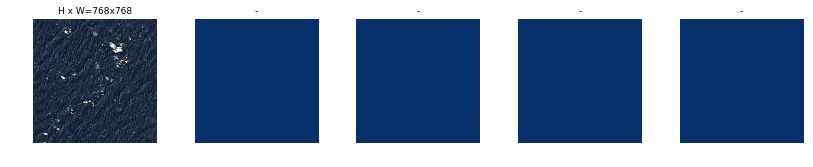

In [6]:
# Load and display 4 random samples
image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [10]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    print(model.find_last())
    model.load_weights(model.find_last(), by_name=True)

FileNotFoundError: [Errno 2] Could not find weight files in /home/ubuntu/Mask_RCNN/logs/ships20180822T1025

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
import warnings
warnings.filterwarnings('ignore')
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=80, 
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
import warnings
warnings.filterwarnings('ignore')
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=140, 
            layers="all")


Starting at epoch 80. LR=0.0001

Checkpoint Path: /home/ubuntu/Mask_RCNN/logs/ships20180821T2110/mask_rcnn_ships_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_bran

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(ShipsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")

model_path = '/home/ubuntu/Mask_RCNN/logs/ships20180820T2119/mask_rcnn_ships_0002.h5'#model.find_last()
model_path = '/home/ubuntu/Mask_RCNN/logs/ships20180821T2110/mask_rcnn_ships_0140.h5'

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/ubuntu/Mask_RCNN/logs/ships20180821T2110/mask_rcnn_ships_0140.h5


### Kaggle submission

In [10]:
from skimage import io
import os
from skimage.morphology import label

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    print(img.ndim)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]
    
def multi( masks):
    return [rle_encode(masks[:,:,x]) for x in range(masks.shape[2])]
    
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    #print(max_mean_threshold, np.mean(img) , max_mean_threshold)
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask

    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

from nms import resultFilter
ignore_list = ['13703f040.jpg','14715c06d.jpg','33e0ff2d5.jpg',
               '4d4e09f2a.jpg','877691df8.jpg', '8b909bb20.jpg',
               'a8d99130e.jpg','ad55c3143.jpg','c8260c541.jpg',
               'd6c7f17c7.jpg','dc3e7c901.jpg','e44dffe88.jpg',
               'ef87bad36.jpg', 'f083256d8.jpg']



test_images = os.listdir(input_dir + '/test/')
# this is pointless if checking below again 
# not exactly sure what this is doing? Why did you add this? 
# for image_id in test_images:
#     test_images.remove(image_id)
    
print('Removed ignore_list from test_images')
print(len(test_images))

row_data = [] # filtererd and nms applied with rle encoding
row_data_masks = [] # filtered plain maks with nms applied (no rle encoding)
row_data_unfil = [] # unfiltererd and nms applied with rle encoding
row_data_masks_unfil = [] # unfiltered plain maks with nms applied (no rle encoding)


for i, image_id in enumerate(test_images):
    if image_id not in ignore_list:
        image = io.imread(input_dir+'/test/'+image_id)
        r = model.detect([image], verbose=0)[0]
        masks =  r['masks']
        filtered_masks = resultFilter(r, scores_threshold=0.9, overlapThresh=0)
        encoded_pred_mask = multi(filtered_masks)
        
        row_data.append(encoded_pred_mask)
        #row_data_unfil.append(multi(r['masks']))
        
        #row_data_masks.append(filtered_masks)
        #row_data_masks_unfil.append(masks)
        if i % 1000 == 0:
            print('Finished step', i)
#     except:
#         row_data.append('')
#         missed.append(image_id)
#         print("some errror with " , image_id)

#np.save('missed.npy', np.array(missed))
np.save('filtered_masks_rle_no_overlap.npy', np.array(row_data))
#np.save('unfiltered_masks_no_overlap.npy', np.array(row_data_masks_unfil))
#np.save('unfiltered_masks_rle_no_overlap.npy' , np.array(row_data_unfil))
#print(len(missed))
#print(len(row_data))
#np.save('filtered_masks_no_overlap.npy' , np.array(row_data_masks))

Removed ignore_list from test_images
88500


NameError: name 'model' is not defined

In [7]:
# from skimage.morphology import label
# runs = np.array([0,1, 1 ,1 ,0, 1,0,0,0])
# # print(np.where(runs[1:] != runs[:-1])[0]+1)
# # runs[1::2] -= runs[::2]
# pixels = np.ones((768,768))

# labels = label(pixels)
# a= np.unique(labels[labels>0])
# print(a)
# rle_encode(np.sum(labels==a[0]))
# pixels = np.concatenate([[0], pixels, [0]])
# print(pixels[1:].shape)
# runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
# print(runs.shape)
# row_data_old = row_data['EncodedPixels']
# print(len(row_data_old))
# a = np.zeros((768,768,3))
# a.shape[2]

# all_masks = np.zeros([768, 768,len(row_data[0])] , dtype=np.uint8)
# print(row_data[1])
# for i,m in enumerate(row_data[0]):
#     if m==m:
#         all_masks[:, :, i] = rle_decode(m)
# print(all_masks)
# plt.imshow(all_masks[:,:])
import os
input_dir = "../../../kaggle-airbus/input"
ignore_list = ['13703f040.jpg','14715c06d.jpg','33e0ff2d5.jpg',
               '4d4e09f2a.jpg','877691df8.jpg', '8b909bb20.jpg',
               'a8d99130e.jpg','ad55c3143.jpg','c8260c541.jpg',
               'd6c7f17c7.jpg','dc3e7c901.jpg','e44dffe88.jpg',
               'ef87bad36.jpg', 'f083256d8.jpg']



test_images = os.listdir(input_dir + '/test/')
filt_test_images = [x for x in test_images if x not in ignore_list]
# len(filt_test_images)
import numpy as np 
row_data = np.load('filtered_masks_rle_no_overlap.npy')
# mod_row_data = ['\n'.join(x) for x in row_data]
mod_row_data = [x[0] if len(x)>0 else '' for x in row_data ]
s = mod_row_data[17].split()
#starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
#print(starts)

In [9]:
import pandas as pd
#mod_row_data = ['\n'.join(x) for x in row_data]
row_data_sub = {'ImageId': filt_test_images, 'EncodedPixels': mod_row_data}
df_sub = pd.DataFrame(row_data_sub, columns=['ImageId', 'EncodedPixels'])
#df.EncodedPixels = df.EncodedPixels.fillna('')
df_sub.to_csv('submission_test5.csv', index=False)
sub_test = pd.read_csv(os.path.join('submission_test5.csv'))
print(sub_test.shape)
error_1 = sub_test.iloc[17]['EncodedPixels']
s = error_1.split()
starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
print(starts)

(88486, 2)
[  1258   2024   2790   3557   4325   5092   5859   6627   7395   8162
   8930   9698  10465  11233  12000  12767  13535  14302  15070  15838
  16605  17373  18140  18908  19675  20443  21210  21978  22745  23513
  24280  25047  25815  26582  27350  28117  28885  29652  30419  31187
  31954  32722  33489  34257  35024  35792  36559  37326  38093  38861
  39628  40395  41163  41930  42697  43465  44233  45000  45767  46534
  47301  48069  48836  49604  50371  51139  51906  52674  53442  54209
  54977  55744  56511  57278  58046  58814  59581  60349  61117  61885
  62653  63420  64188  64956  65723  66491  67258  68026  68793  69561
  70328  71096  71863  72630  73398  74165  74933  75700  76468  77235
  78003  78770  79538  80305  81072  81840  82607  83371  84138  84905
  85666  85672  86433  86439  87201  87968  88736  89503  90270  91036
  91802  92569  93337  94104  94871  95639  96407  97174  97942  98710
  99478 100246 101014 101782 102550 103319 104087 104855 105624 10

In [27]:
sub_test = pd.read_csv(os.path.join('submission_test1.csv'))
sub_test.head()

,ImageId,EncodedPixels
0,421446008.jpg,NaN
1,dee88169c.jpg,26870 11 27635 14 28397 20 29161 24 29925 28 3...
2,a585f9fa9.jpg,NaN
3,3019702c6.jpg,NaN
4,dab00c184.jpg,NaN


In [82]:
np.array([1,2,3])

array([1, 2, 3])

## It is not testing on the real set as we dont have GT for test

In [57]:
# Test on a random image from val set
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

NameError: name 'dataset_val' is not defined

In [28]:
results = model.detect([original_image], verbose=1)

r = results[0]
temp = r['scores']
filt_ids = temp>0.8 # stupid filtering 
print(len(filt_ids), " ships" )

visualize.display_instances(original_image, r['rois'][filt_ids], r['masks'][:,:,filt_ids], r['class_ids'][filt_ids], 
                            dataset_val.class_names, r['scores'][filt_ids], ax=get_ax())

NameError: name 'original_image' is not defined

## Test on real testset

88500
dee88169c.jpg
dee88169c.jpg
Processing 1 images
image                    shape: (768, 768, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 768, 768, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  768.00000  int64
anchors                  shape: (1, 147312, 4)        min:   -0.11800  max:    1.03456  float32


/home/ubuntu/venv/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


ex time 0.5140955448150635
20  ships



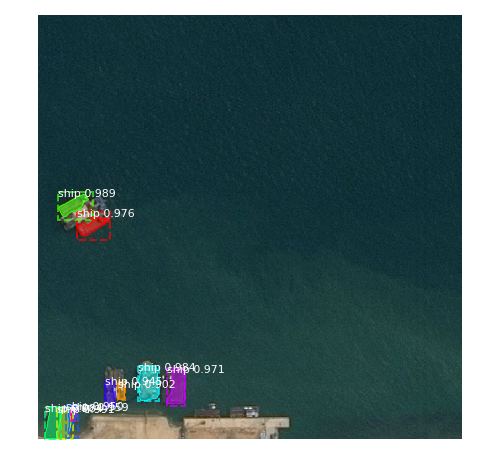

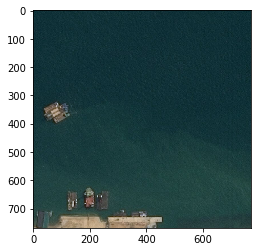

In [71]:
test = os.listdir(input_dir+'/test')
import skimage
from nms import resultFilter
print(len(test))
image_id = random.choice(test)
image_id = test[1]
print(image_id)
image = skimage.io.imread(input_dir+'/test/'+image_id)

print(image_id)
start = time.time()
results = model.detect([image], verbose=1)
end = time.time()
print("ex time" ,end-start)

r = results[0]
temp = r['scores']
filt_ids = temp>0.9 # stupid filtering 
print(len(filt_ids), " ships" )

print()

visualize.display_instances(image, r['rois'][filt_ids], r['masks'][:,:,filt_ids], r['class_ids'][filt_ids], 
                            dataset_val.class_names, r['scores'][filt_ids], ax=get_ax())
plt.figure()
plt.imshow(image)

In [35]:
from skimage.morphology import label
from nms import rle_decode
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]
    
rle_decode(multi_rle_encode(r['masks'][:,:,filt_ids])[0])
print(type(r['masks']))
row_data_nofilter = [] 
row_data_nofilter.append(r['masks'])
#print(row_data_nofilter)

IndexError: list index out of range

In [ ]:
# TODO Write code to ignore overlapped instances  and some better filtering 
    
ignore_list = ['13703f040.jpg','14715c06d.jpg','33e0ff2d5.jpg',
               '4d4e09f2a.jpg','877691df8.jpg', '8b909bb20.jpg',
               'a8d99130e.jpg','ad55c3143.jpg','c8260c541.jpg',
               'd6c7f17c7.jpg','dc3e7c901.jpg','e44dffe88.jpg',
               'ef87bad36.jpg', 'f083256d8.jpg'] 

for image_id in test:
    if image_id not in ignore_list:
        image = imread(input_dir+'/test/'+image_id)
        #TODO
        #instance_count = model.detectandfilter(image)
        # run rle to create csv 


In [80]:
# TODO Write submit code for kaggle
masks = pd.read_csv(input_dir+'/sample_submission.csv')

FileNotFoundError: File b'../../../kaggle-airbus/input/sample_submission.csv' does not exist

## Evaluation

In [ ]:
# This is useless we can remove it.!!

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    #TODO: currently this cell breaks when gt_mask is empty, or r['masks'] is empty or both
    # So fails when there is no ship on it, quelle surprise!
    print('gt mask')
    #print(gt_mask)
    print(np.sum(gt_mask))
    print(np.sum(gt_class_id))
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    #print(r['rois'])
    print(r['class_ids'])
    #print(r['scores'])
    print('predicted masks')
    #print(r['masks'])
    print(np.sum(r['masks']))
    visualize.display_images([image])
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))